In [23]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from random import shuffle
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import os
from sympy import *
import math
import openpyxl

In [35]:
from openpyxl import load_workbook

input_train=np.zeros((560,4,4,1),dtype=np.float32)
input_train_xlsx=load_workbook(filename='input_train.xlsx')
sheet = input_train_xlsx['Sheet']
for i in range(len(input_train)):
    for j in range(len(input_train[0,:,:,:])):
        for k in range(len(input_train[0,0,:,:])):
            input_train[i,j,k,0]=sheet.cell(row=4*i+j+1, column=k+1).value
            
input_test=np.zeros((1330,4,4,1),dtype=np.float32)
input_test_xlsx=load_workbook(filename='input_test.xlsx')
sheet = input_test_xlsx['Sheet']
for i in range(len(input_test)):
    for j in range(len(input_test[0,:,:,:])):
        for k in range(len(input_test[0,0,:,:])):
            input_test[i,j,k,0]=sheet.cell(row=4*i+j+1, column=k+1).value
            
label_train_x=np.zeros((560,1),dtype=np.float32)
label_train_x_xlsx=load_workbook(filename='label_train_x.xlsx')
sheet = label_train_x_xlsx['Sheet']
for i in range(len(label_train_x)):
    label_train_x[i,0]=sheet.cell(row=i+1, column=1).value
    
label_train_y=np.zeros((560,1),dtype=np.float32)
label_train_y_xlsx=load_workbook(filename='label_train_y.xlsx')
sheet = label_train_y_xlsx['Sheet']
for i in range(len(label_train_y)):
    label_train_y[i,0]=sheet.cell(row=i+1, column=1).value
    
label_test_x=np.zeros((1330,1),dtype=np.float32)
label_test_x_xlsx=load_workbook(filename='label_test_x.xlsx')
sheet = label_test_x_xlsx['Sheet']
for i in range(len(label_test_x)):
    label_test_x[i,0]=sheet.cell(row=i+1, column=1).value
    
label_test_y=np.zeros((1330,1),dtype=np.float32)
label_test_y_xlsx=load_workbook(filename='label_test_y.xlsx')
sheet = label_test_y_xlsx['Sheet']
for i in range(len(label_test_y)):
    label_test_y[i,0]=sheet.cell(row=i+1, column=1).value

In [36]:
### Data set PreProcessing, compensation of measuring error and normalizing ###
input_train[:,:,0,0]+=-0.00238
input_train[:,:,1,0]+=0.001496742
input_train[:,:,2,0]+=0.009334
input_train[:,:,3,0]+=-0.00588
input_test[:,:,0,0]+=-0.00238
input_test[:,:,1,0]+=0.001496742
input_test[:,:,2,0]+=0.009334
input_test[:,:,3,0]+=-0.00588
input_train[:,0,0,0]=0
input_train[:,1,1,0]=0
input_train[:,2,2,0]=0
input_train[:,3,3,0]=0
input_test[:,0,0,0]=0
input_test[:,1,1,0]=0
input_test[:,2,2,0]=0
input_test[:,3,3,0]=0
for i in range(len(input_train)):
    for j in range(4):
        input_train[i,j,0:4,:]=input_train[i,j,0:4,:]/max(input_train[i,j,0:4,:])
for i in range(len(input_test)):
    for j in range(4):
        input_test[i,j,0:4,:]=input_test[i,j,0:4,:]/max(input_test[i,j,0:4,:])

In [44]:
learning_rate_x = 0.00001
learning_rate_y = 0.00001
training_epochs = 10000
batch_size = 560
test_batch_size = 1330

In [38]:
train_dataset_x = tf.data.Dataset.from_tensor_slices((input_train, label_train_x)).shuffle(buffer_size=100000).batch(batch_size)
train_dataset_y = tf.data.Dataset.from_tensor_slices((input_train, label_train_y)).shuffle(buffer_size=100000).batch(batch_size)
test_dataset_x = tf.data.Dataset.from_tensor_slices((input_test, label_test_x)).batch(test_batch_size)
test_dataset_y = tf.data.Dataset.from_tensor_slices((input_test, label_test_y)).batch(test_batch_size)

In [39]:
regularizer_constant=0.0001

def create_model_x():
    model=keras.Sequential() 
    model.add(keras.layers.GaussianNoise(0.0005, input_shape=(4,4,1)))
    model.add(keras.layers.Conv2D(filters=1024, kernel_size=(1,4), activation=tf.nn.leaky_relu, strides=[1,1],kernel_regularizer=keras.regularizers.l2(regularizer_constant)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024,activation=tf.nn.leaky_relu, kernel_regularizer=keras.regularizers.l2(regularizer_constant)))
    model.add(keras.layers.Dense(1,kernel_regularizer=keras.regularizers.l2(regularizer_constant)))
    return model

def create_model_y():
    model=keras.Sequential() 
    model.add(keras.layers.GaussianNoise(0.0005, input_shape=(4,4,1)))
    model.add(keras.layers.Conv2D(filters=1024, kernel_size=(1,4), activation=tf.nn.leaky_relu, strides=[1,1],kernel_regularizer=keras.regularizers.l2(regularizer_constant)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024,activation=tf.nn.leaky_relu, kernel_regularizer=keras.regularizers.l2(regularizer_constant)))
    model.add(keras.layers.Dense(1,kernel_regularizer=keras.regularizers.l2(regularizer_constant)))
    return model

In [40]:
model_x=create_model_x()
model_y=create_model_y()
model_x.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_6 (GaussianNo (None, 4, 4, 1)           0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 1, 1024)        5120      
_________________________________________________________________
flatten_6 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 1025      
Total params: 4,201,473
Trainable params: 4,201,473
Non-trainable params: 0
_________________________________________________________________


In [41]:
def loss_fn_x(model_x, images_x, labels_x):
    logits_x = model_x(images_x, training=True)
    loss_x = tf.reduce_mean((tf.square(logits_x-labels_x)))+tf.reduce_sum(model_x.losses)
    return loss_x
def loss_fn_y(model_y, images_y, labels_y):
    logits_y = model_y(images_y, training=True)
    loss_y = tf.reduce_mean((tf.square(logits_y-labels_y)))+tf.reduce_sum(model_y.losses)
    return loss_y

def grad_x(model_x, images_x, labels_x):
    with tf.GradientTape() as tape:
        loss_x = loss_fn_x(model_x, images_x, labels_x)
    return tape.gradient(loss_x, model_x.variables)
def grad_y(model_y, images_y, labels_y):
    with tf.GradientTape() as tape:
        loss_y = loss_fn_y(model_y, images_y, labels_y)
    return tape.gradient(loss_y, model_y.variables)

In [45]:
optimizer_x = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate_x)
optimizer_y = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate_y)
def evaluate_x(model_x, images_x, labels_x):
    logits_x=model_x(images_x, training=False)
    correct_prediction_x=tf.reduce_sum(abs(labels_x-logits_x))*28.9/len(labels_x)
    accuracy_x=abs(correct_prediction_x)
    return accuracy_x
def evaluate_y(model_y, images_y, labels_y):
    logits_y=model_y(images_y, training=False)
    correct_prediction_y=tf.reduce_sum(abs(labels_y-logits_y))*16.2/len(labels_y)
    accuracy_y=abs(correct_prediction_y)
    return accuracy_y

In [48]:
avg_test_acc_x_ref=1.
avg_test_acc_y_ref=1.
avg_train_acc_x_ref=1.
avg_train_acc_y_ref=1.
stop_rate_x=0.087
stop_rate_y=0.086
for epoch in range(training_epochs):
    avg_loss_x=0.
    avg_loss_y=0.
    avg_train_acc_x=0.
    avg_train_acc_y=0.
    avg_test_acc_x=0.
    avg_test_acc_y=0.
    train_step=0
    test_step=0
    if ((avg_train_acc_x_ref>stop_rate_x)):
        for images_x, labels_x in train_dataset_x:
            grads_x = grad_x(model_x, images_x, labels_x)
            optimizer_x.apply_gradients(zip(grads_x, model_x.variables))
            train_step+=1
    train_step=0
    if ((avg_train_acc_y_ref>stop_rate_y)):
        for images_y, labels_y in train_dataset_y:
            grads_y = grad_y(model_y, images_y, labels_y)
            optimizer_y.apply_gradients(zip(grads_y, model_y.variables))
            train_step+=1
    train_step=0
    
    
    for images_x, labels_x in test_dataset_x:
        acc_x=evaluate_x(model_x, images_x, labels_x)
        avg_test_acc_x=avg_test_acc_x+acc_x
        test_step+=1
    avg_test_acc_x=avg_test_acc_x/test_step
    test_step=0
    for images_x, labels_x in train_dataset_x:
        acc_x=evaluate_x(model_x, images_x, labels_x)
        avg_train_acc_x=avg_train_acc_x+acc_x
        test_step+=1
    avg_train_acc_x=avg_train_acc_x/test_step
    test_step=0
    
    for images_y, labels_y in test_dataset_y:
        acc_y=evaluate_y(model_y, images_y, labels_y)
        avg_test_acc_y=avg_test_acc_y+acc_y
        test_step+=1    
    avg_test_acc_y=avg_test_acc_y/test_step
    test_step=0
    for images_y, labels_y in train_dataset_y:
        acc_y=evaluate_y(model_y, images_y, labels_y)
        avg_train_acc_y=avg_train_acc_y+acc_y
        test_step+=1    
    avg_train_acc_y=avg_train_acc_y/test_step
    test_step=0

    avg_test_acc_x_ref=avg_test_acc_x
    avg_train_acc_x_ref=avg_train_acc_x
    avg_test_acc_y_ref=avg_test_acc_y
    avg_train_acc_y_ref=avg_train_acc_y
    print('Epoch:', '{}'.format(epoch+1), '|| (avg delta x, avg delta y) ','|| avg train delta = ','(', '{:.4f}'.format(avg_train_acc_x), 'cm, ', '{:.4f}'.format(avg_train_acc_y), 'cm)', '|| avg test delta = ','(', '{:.4f}'.format(avg_test_acc_x), 'cm, ', '{:.4f}'.format(avg_test_acc_y), 'cm)')
    if (avg_train_acc_x_ref<stop_rate_x) and (avg_train_acc_y_ref<stop_rate_y):
        break
#'|| x_loss =', '{:.12f}'.format(avg_loss_x), '|| y_loss =', '{:.12f}'.format(avg_loss_y),

Epoch: 1 || (avg delta x, avg delta y)  || avg train delta =  ( 0.0799 cm,  0.0717 cm) || avg test delta =  ( 0.0851 cm,  0.0691 cm)


In [49]:
num=560
av_a=0
av_b=0
x_train=np.zeros((num,1),dtype=np.float32)
y_train=np.zeros((num,1),dtype=np.float32)
d_train=np.zeros((num,1),dtype=np.float32)
for i in range(num):
    a=(model_x(input_train, training=False)-label_train_x)[i,0]*28.9
    b=(model_y(input_train, training=False)-label_train_y)[i,0]*16.2
    c=pow(a**2+b**2, 0.5)
    x_train[i,0]=a
    y_train[i,0]=b
    d_train[i,0]=c
    print('number :', i+1,'{:.4f}'.format(a),'cm  ,' , '{:.4f}'.format(b),'cm')
    av_a=av_a+abs(a)
    av_b=av_b+abs(b)
av_a/=num
av_b/=num
print('average :', '{:.4f}'.format(av_a),'cm , ','{:.4f}'.format(av_b), 'cm')
x_dev=pow(tf.reduce_mean(tf.square(abs(x_train)-av_a)), 0.5)
y_dev=pow(tf.reduce_mean(tf.square(abs(y_train)-av_b)), 0.5)
print('x_SDev : ', '{:.4f}'.format(x_dev))
print('y_SDev : ', '{:.4f}'.format(y_dev))
print('avg(dx^2+dy^2)^(1/2) : ', '{:.4f}'.format(pow(av_a**2+av_b**2,0.5)), ' cm')
print('SDEv(dx^2+dy^2)^(1/2) : ', '{:.4f}'.format(pow(tf.reduce_mean(tf.square(abs(d_train)-tf.reduce_mean(abs(d_train)))), 0.5)))
print('Max_Dev(dx^2+dy^2)^(1/2) : ', '{:.4f}'.format(max(d_train[:,0])), 'cm')

number : 1 0.3417 cm  , 0.1570 cm
number : 2 0.3736 cm  , 0.2261 cm
number : 3 0.2953 cm  , 0.2106 cm
number : 4 0.3297 cm  , 0.1799 cm
number : 5 0.3177 cm  , 0.2070 cm
number : 6 0.3504 cm  , 0.1446 cm
number : 7 0.3795 cm  , 0.2294 cm
number : 8 0.2965 cm  , 0.2057 cm
number : 9 0.3326 cm  , 0.1631 cm
number : 10 0.3434 cm  , 0.2092 cm
number : 11 0.3702 cm  , 0.1234 cm
number : 12 0.3380 cm  , 0.1466 cm
number : 13 0.3418 cm  , 0.1833 cm
number : 14 0.3605 cm  , 0.1293 cm
number : 15 0.3166 cm  , 0.1477 cm
number : 16 0.3359 cm  , 0.1611 cm
number : 17 0.3661 cm  , 0.1410 cm
number : 18 0.3467 cm  , 0.1845 cm
number : 19 0.3633 cm  , 0.1159 cm
number : 20 0.3252 cm  , 0.1442 cm
number : 21 0.1087 cm  , 0.1742 cm
number : 22 0.1392 cm  , 0.1382 cm
number : 23 0.1068 cm  , 0.1563 cm
number : 24 0.1560 cm  , 0.1361 cm
number : 25 0.1441 cm  , 0.1555 cm
number : 26 0.1086 cm  , 0.1733 cm
number : 27 0.1378 cm  , 0.1289 cm
number : 28 0.1206 cm  , 0.1496 cm
number : 29 0.1469 cm  , 0.12

number : 230 -0.0905 cm  , -0.0272 cm
number : 231 -0.0399 cm  , -0.0131 cm
number : 232 -0.0409 cm  , 0.0159 cm
number : 233 -0.0448 cm  , -0.0289 cm
number : 234 -0.0182 cm  , -0.0026 cm
number : 235 -0.0532 cm  , -0.0254 cm
number : 236 -0.0366 cm  , -0.0264 cm
number : 237 -0.0626 cm  , 0.0152 cm
number : 238 -0.0498 cm  , -0.0394 cm
number : 239 -0.0224 cm  , -0.0146 cm
number : 240 -0.0618 cm  , -0.0236 cm
number : 241 -0.1316 cm  , 0.0363 cm
number : 242 -0.1701 cm  , 0.0666 cm
number : 243 -0.0790 cm  , 0.0650 cm
number : 244 -0.1510 cm  , 0.0477 cm
number : 245 -0.1483 cm  , 0.0878 cm
number : 246 -0.1293 cm  , 0.0291 cm
number : 247 -0.2057 cm  , 0.0512 cm
number : 248 -0.0908 cm  , 0.0616 cm
number : 249 -0.1451 cm  , 0.0285 cm
number : 250 -0.1131 cm  , 0.0688 cm
number : 251 -0.0445 cm  , 0.0295 cm
number : 252 -0.0413 cm  , 0.0733 cm
number : 253 -0.0309 cm  , 0.0202 cm
number : 254 -0.0479 cm  , 0.0426 cm
number : 255 -0.0414 cm  , 0.0623 cm
number : 256 -0.0405 cm  , 0.

number : 453 0.0306 cm  , -0.0070 cm
number : 454 -0.0345 cm  , -0.0618 cm
number : 455 0.0399 cm  , -0.0184 cm
number : 456 -0.0386 cm  , -0.0166 cm
number : 457 -0.0180 cm  , -0.0287 cm
number : 458 0.0908 cm  , -0.0082 cm
number : 459 -0.0842 cm  , -0.0143 cm
number : 460 0.0096 cm  , -0.0276 cm
number : 461 0.0638 cm  , -0.0868 cm
number : 462 0.0332 cm  , -0.0981 cm
number : 463 0.1341 cm  , -0.0769 cm
number : 464 0.0113 cm  , -0.0892 cm
number : 465 0.0580 cm  , -0.1029 cm
number : 466 0.0847 cm  , -0.1027 cm
number : 467 0.0283 cm  , -0.1134 cm
number : 468 0.1019 cm  , -0.0886 cm
number : 469 0.0372 cm  , -0.0983 cm
number : 470 0.0570 cm  , -0.1058 cm
number : 471 0.0463 cm  , -0.0587 cm
number : 472 -0.0484 cm  , -0.0844 cm
number : 473 -0.0101 cm  , -0.0574 cm
number : 474 0.0263 cm  , -0.0657 cm
number : 475 -0.0383 cm  , -0.0741 cm
number : 476 0.0297 cm  , -0.0690 cm
number : 477 -0.0253 cm  , -0.1043 cm
number : 478 -0.0291 cm  , -0.0696 cm
number : 479 0.0848 cm  , -0.

In [50]:
num=1330
av_a=0
av_b=0
x_test=np.zeros((num,1),dtype=np.float32)
y_test=np.zeros((num,1),dtype=np.float32)
d_train=np.zeros((num,1),dtype=np.float32)
for i in range(num):
    a=(model_x(input_test, training=False)-label_test_x)[i,0]*28.9
    b=(model_y(input_test, training=False)-label_test_y)[i,0]*16.2
    c=pow(a**2+b**2, 0.5)
    x_test[i,0]=a
    y_test[i,0]=b
    d_train[i,0]=c
    print('number :', i+1,'{:.4f}'.format(a),'cm  ,' , '{:.4f}'.format(b),'cm')
    av_a=av_a+abs(a)
    av_b=av_b+abs(b)
av_a/=num
av_b/=num
print('average :', '{:.4f}'.format(av_a),'cm , ','{:.4f}'.format(av_b), 'cm')
x_dev=pow(tf.reduce_mean(tf.square(abs(x_test)-av_a)), 0.5)
y_dev=pow(tf.reduce_mean(tf.square(abs(y_test)-av_b)), 0.5)
print('x_SDev : ', '{:.4f}'.format(x_dev))
print('y_SDev : ', '{:.4f}'.format(y_dev))
print('avg(dx^2+dy^2)^(1/2) : ', '{:.4f}'.format(pow(av_a**2+av_b**2,0.5)), ' cm')
print('SDEv(dx^2+dy^2)^(1/2) : ', '{:.4f}'.format(pow(tf.reduce_mean(tf.square(abs(d_train)-tf.reduce_mean(abs(d_train)))), 0.5)))
print('Max_Dev(dx^2+dy^2)^(1/2) : ', '{:.4f}'.format(max(d_train[:,0])), 'cm')

number : 1 0.4231 cm  , 0.1286 cm
number : 2 0.3735 cm  , 0.1607 cm
number : 3 0.4141 cm  , 0.1955 cm
number : 4 0.4418 cm  , 0.1575 cm
number : 5 0.3797 cm  , 0.1728 cm
number : 6 0.3788 cm  , 0.1733 cm
number : 7 0.3755 cm  , 0.1423 cm
number : 8 0.4074 cm  , 0.1878 cm
number : 9 0.4315 cm  , 0.1401 cm
number : 10 0.3713 cm  , 0.1581 cm
number : 11 0.2629 cm  , 0.2181 cm
number : 12 0.2531 cm  , 0.2305 cm
number : 13 0.1860 cm  , 0.2412 cm
number : 14 0.2665 cm  , 0.2213 cm
number : 15 0.2406 cm  , 0.2409 cm
number : 16 0.2152 cm  , 0.2575 cm
number : 17 0.2454 cm  , 0.2131 cm
number : 18 0.2028 cm  , 0.2311 cm
number : 19 0.2778 cm  , 0.2138 cm
number : 20 0.2631 cm  , 0.2347 cm
number : 21 -0.0104 cm  , 0.1841 cm
number : 22 0.0340 cm  , 0.1442 cm
number : 23 0.0024 cm  , 0.1654 cm
number : 24 0.0448 cm  , 0.1434 cm
number : 25 0.0411 cm  , 0.1580 cm
number : 26 0.0006 cm  , 0.1844 cm
number : 27 0.0424 cm  , 0.1418 cm
number : 28 0.0336 cm  , 0.1649 cm
number : 29 0.0310 cm  , 0.1

number : 230 0.1123 cm  , 0.0828 cm
number : 231 0.0914 cm  , 0.0701 cm
number : 232 0.1280 cm  , 0.0801 cm
number : 233 0.1074 cm  , 0.0811 cm
number : 234 0.1126 cm  , 0.0580 cm
number : 235 0.1299 cm  , 0.0822 cm
number : 236 0.1013 cm  , 0.0646 cm
number : 237 0.1315 cm  , 0.0751 cm
number : 238 0.1271 cm  , 0.0802 cm
number : 239 0.0766 cm  , 0.0435 cm
number : 240 0.1310 cm  , 0.0695 cm
number : 241 -0.0652 cm  , -0.0068 cm
number : 242 -0.0261 cm  , -0.0253 cm
number : 243 -0.0376 cm  , -0.0051 cm
number : 244 -0.0965 cm  , -0.0300 cm
number : 245 -0.0286 cm  , -0.0053 cm
number : 246 -0.0560 cm  , -0.0078 cm
number : 247 -0.0534 cm  , -0.0263 cm
number : 248 -0.0027 cm  , -0.0045 cm
number : 249 -0.0907 cm  , -0.0302 cm
number : 250 -0.0158 cm  , -0.0114 cm
number : 251 -0.0151 cm  , 0.0437 cm
number : 252 -0.0021 cm  , 0.0350 cm
number : 253 0.0088 cm  , 0.0546 cm
number : 254 -0.0631 cm  , 0.0233 cm
number : 255 -0.0004 cm  , 0.0422 cm
number : 256 -0.0041 cm  , 0.0493 cm
num

number : 453 -0.0088 cm  , 0.0400 cm
number : 454 -0.0977 cm  , 0.0246 cm
number : 455 -0.0247 cm  , 0.0033 cm
number : 456 -0.0547 cm  , 0.0300 cm
number : 457 -0.0832 cm  , 0.0041 cm
number : 458 -0.0034 cm  , 0.0366 cm
number : 459 -0.0816 cm  , 0.0227 cm
number : 460 -0.0621 cm  , -0.0070 cm
number : 461 0.0038 cm  , 0.0062 cm
number : 462 -0.0212 cm  , -0.0279 cm
number : 463 0.0604 cm  , -0.0160 cm
number : 464 -0.0279 cm  , -0.0095 cm
number : 465 -0.0008 cm  , -0.0353 cm
number : 466 0.0119 cm  , -0.0044 cm
number : 467 -0.0365 cm  , -0.0347 cm
number : 468 0.0461 cm  , -0.0275 cm
number : 469 -0.0068 cm  , -0.0160 cm
number : 470 -0.0211 cm  , -0.0408 cm
number : 471 -0.0886 cm  , 0.0263 cm
number : 472 -0.1850 cm  , 0.0256 cm
number : 473 -0.1312 cm  , 0.0084 cm
number : 474 -0.1402 cm  , 0.0455 cm
number : 475 -0.1758 cm  , 0.0009 cm
number : 476 -0.1071 cm  , 0.0149 cm
number : 477 -0.1834 cm  , 0.0233 cm
number : 478 -0.1394 cm  , -0.0025 cm
number : 479 -0.1352 cm  , 0.03

number : 673 -0.0613 cm  , 0.0585 cm
number : 674 -0.0615 cm  , 0.0950 cm
number : 675 -0.1105 cm  , 0.0543 cm
number : 676 -0.0246 cm  , 0.0569 cm
number : 677 -0.1208 cm  , 0.0712 cm
number : 678 -0.0736 cm  , 0.0494 cm
number : 679 -0.0514 cm  , 0.0905 cm
number : 680 -0.1123 cm  , 0.0530 cm
number : 681 0.0581 cm  , 0.1144 cm
number : 682 -0.0112 cm  , 0.1169 cm
number : 683 0.0347 cm  , 0.0959 cm
number : 684 0.0387 cm  , 0.1384 cm
number : 685 -0.0097 cm  , 0.0979 cm
number : 686 0.0552 cm  , 0.0985 cm
number : 687 -0.0135 cm  , 0.1136 cm
number : 688 0.0194 cm  , 0.0957 cm
number : 689 0.0890 cm  , 0.1148 cm
number : 690 -0.0137 cm  , 0.0981 cm
number : 691 0.0251 cm  , 0.1164 cm
number : 692 0.0251 cm  , 0.1487 cm
number : 693 -0.0000 cm  , 0.1122 cm
number : 694 0.0609 cm  , 0.1225 cm
number : 695 -0.0203 cm  , 0.1106 cm
number : 696 0.0193 cm  , 0.1092 cm
number : 697 -0.0073 cm  , 0.1521 cm
number : 698 -0.0074 cm  , 0.1014 cm
number : 699 0.0434 cm  , 0.1157 cm
number : 700

number : 893 0.0099 cm  , -0.0034 cm
number : 894 0.0170 cm  , -0.0061 cm
number : 895 0.0749 cm  , 0.0039 cm
number : 896 0.0137 cm  , -0.0202 cm
number : 897 -0.0120 cm  , -0.0100 cm
number : 898 0.0053 cm  , -0.0103 cm
number : 899 0.0096 cm  , -0.0222 cm
number : 900 0.0553 cm  , 0.0014 cm
number : 901 0.0175 cm  , 0.1280 cm
number : 902 -0.0153 cm  , 0.1357 cm
number : 903 0.0579 cm  , 0.1532 cm
number : 904 0.0005 cm  , 0.1189 cm
number : 905 0.0345 cm  , 0.1373 cm
number : 906 0.0094 cm  , 0.1162 cm
number : 907 -0.0432 cm  , 0.1227 cm
number : 908 0.1022 cm  , 0.1329 cm
number : 909 0.0054 cm  , 0.1109 cm
number : 910 0.0090 cm  , 0.1276 cm
number : 911 -0.0630 cm  , 0.0966 cm
number : 912 -0.0917 cm  , 0.1008 cm
number : 913 0.0525 cm  , 0.1102 cm
number : 914 -0.0622 cm  , 0.0936 cm
number : 915 -0.0568 cm  , 0.1101 cm
number : 916 -0.0498 cm  , 0.0832 cm
number : 917 -0.1109 cm  , 0.0923 cm
number : 918 0.0236 cm  , 0.1004 cm
number : 919 -0.0627 cm  , 0.0818 cm
number : 920

number : 1111 0.0324 cm  , -0.0644 cm
number : 1112 0.0211 cm  , -0.0596 cm
number : 1113 0.0334 cm  , -0.0638 cm
number : 1114 0.0400 cm  , -0.0647 cm
number : 1115 0.1004 cm  , -0.0477 cm
number : 1116 0.0246 cm  , -0.0747 cm
number : 1117 0.0047 cm  , -0.0775 cm
number : 1118 0.0369 cm  , -0.0677 cm
number : 1119 0.0314 cm  , -0.0677 cm
number : 1120 0.0686 cm  , -0.0565 cm
number : 1121 0.0419 cm  , -0.0946 cm
number : 1122 0.0295 cm  , -0.0924 cm
number : 1123 0.0426 cm  , -0.0842 cm
number : 1124 0.0325 cm  , -0.0893 cm
number : 1125 0.0735 cm  , -0.0823 cm
number : 1126 0.0386 cm  , -0.0915 cm
number : 1127 0.0015 cm  , -0.1007 cm
number : 1128 0.1374 cm  , -0.0827 cm
number : 1129 0.0359 cm  , -0.0918 cm
number : 1130 0.0510 cm  , -0.0875 cm
number : 1131 -0.0054 cm  , -0.0503 cm
number : 1132 -0.0349 cm  , -0.0487 cm
number : 1133 0.0901 cm  , -0.0316 cm
number : 1134 -0.0213 cm  , -0.0447 cm
number : 1135 0.0164 cm  , -0.0409 cm
number : 1136 -0.0126 cm  , -0.0548 cm
number :

number : 1324 -0.0817 cm  , -0.1263 cm
number : 1325 -0.0732 cm  , -0.1245 cm
number : 1326 -0.0016 cm  , -0.1254 cm
number : 1327 -0.0990 cm  , -0.1288 cm
number : 1328 -0.0544 cm  , -0.1359 cm
number : 1329 -0.0083 cm  , -0.1511 cm
number : 1330 -0.0932 cm  , -0.1383 cm
average : 0.0851 cm ,  0.0691 cm
x_SDev :  0.0634
y_SDev :  0.0492
avg(dx^2+dy^2)^(1/2) :  0.1096  cm
SDEv(dx^2+dy^2)^(1/2) :  0.0632
Max_Dev(dx^2+dy^2)^(1/2) :  0.4691 cm


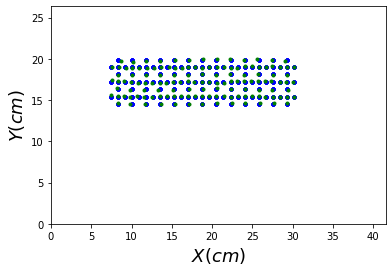

In [51]:
plot_test_x=np.zeros((133,1),dtype=np.float32)
a=model_x(input_test, training=False)
b=model_y(input_test, training=False)
for i in range(133):
    plot_test_x[i,0]=a[10*i+5,0]
    
plot_test_y=np.zeros((133,1),dtype=np.float32)
for i in range(133):
    plot_test_y[i,0]=b[10*i+5,0]

plt.plot(label_test_x*28.9+7.4, (1-label_test_y)*16.2+4.6, "b.", plot_test_x*28.9+7.4, (1-plot_test_y)*16.2+4.6, "g.")
plt.xlabel("$X (cm)$", fontsize=18)
plt.ylabel("$Y (cm)$", rotation=90, fontsize=18)
plt.axis([0, 41.55, 0, 26.35])
plt.savefig('testing_point_balpyo3.png', format='png', dpi=1080)
plt.show()

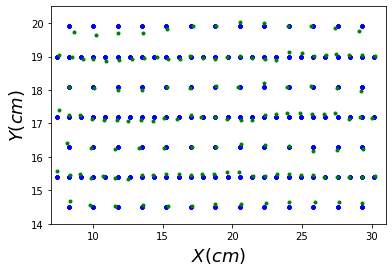

In [52]:
plot_test_x=np.zeros((133,1),dtype=np.float32)
a=model_x(input_test, training=False)
b=model_y(input_test, training=False)
for i in range(133):
    plot_test_x[i,0]=a[10*i+5,0]
    
plot_test_y=np.zeros((133,1),dtype=np.float32)
for i in range(133):
    plot_test_y[i,0]=b[10*i+5,0]

plt.plot(label_test_x*28.9+7.4, (1-label_test_y)*16.2+4.6, "b.", plot_test_x*28.9+7.4, (1-plot_test_y)*16.2+4.6, "g.")
plt.xlabel("$X (cm)$", rotation=0, fontsize=18)
plt.ylabel("$Y (cm)$", rotation=90, fontsize=18)
plt.axis([7, 31, 14, 20.5])
plt.savefig('testing_point_balpyo4.png', format='png', dpi=1080)
plt.show()

In [239]:
diagonal_length_SCAPTP=pow(41.55**2+26.35**2, 0.5)

In [242]:
pow(24**2+6.5**2, 0.5)

24.86463351831271